In [1]:
import numpy as np
np.random.seed(123)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from changepoynt.algorithms.sst import SST
from changepoynt.visualization.score_plotting import plot_data_and_score

In [2]:
# make synthetic step function
x0 = 1 * np.ones(500) + np.random.rand(500) * 1
x1 = 3 * np.ones(500) + np.random.rand(500) * 2
x2 = 5 * np.ones(500) + np.random.rand(500) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

In [3]:
# measure the timings and also plot them
def time_per_window_length(window_length, method, n_iter=10):

    # create the SST object
    sst = SST(window_length, method=method)

    # compute the scores and add to the timing
    measured_time = 0
    for idx in range(n_iter):
        start = time.perf_counter()
        sst.transform(x)
        measured_time += time.perf_counter()-start
    return measured_time / n_iter

def measure_time_and_plot():
    # measure the two methods for different timings
    win_lengths_candidates = np.logspace(1.47712125472,2,5).astype(int) # 30 to 100

    # trigger the jit compilation so comparison is fair
    SST(30, method='ika').transform(x)
    SST(30, method='svd').transform(x)
    SST(30, method='fbrsvd').transform(x)
    SST(30, method='rsvd').transform(x)
    SST(30, method='naive').transform(x)

    methods = []
    measured_times = []
    window_lengths = []

    for method in ("naive", "svd", "ika", "fbrsvd", "rsvd"):
        for wl in win_lengths_candidates:
            for j in range(10):
                measured_times.append(time_per_window_length(wl, method=method, n_iter=1))
                methods.append(method)
                window_lengths.append(wl)

    df = pd.DataFrame({"time[s]": measured_times, "method":methods, "window length":window_lengths})
    sns.barplot(x="window length", y="time[s]", hue="method", data=df)

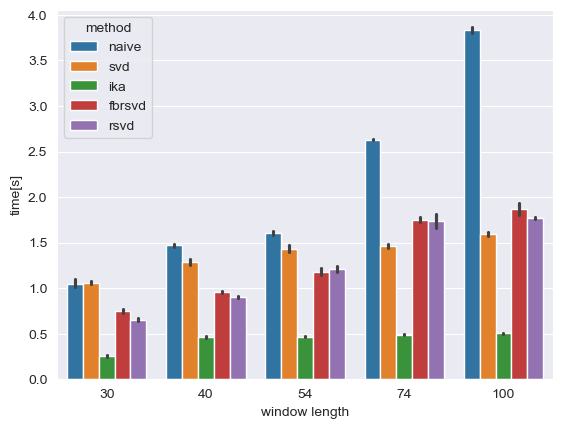

In [4]:
measure_time_and_plot()  # takes about 5-10min!

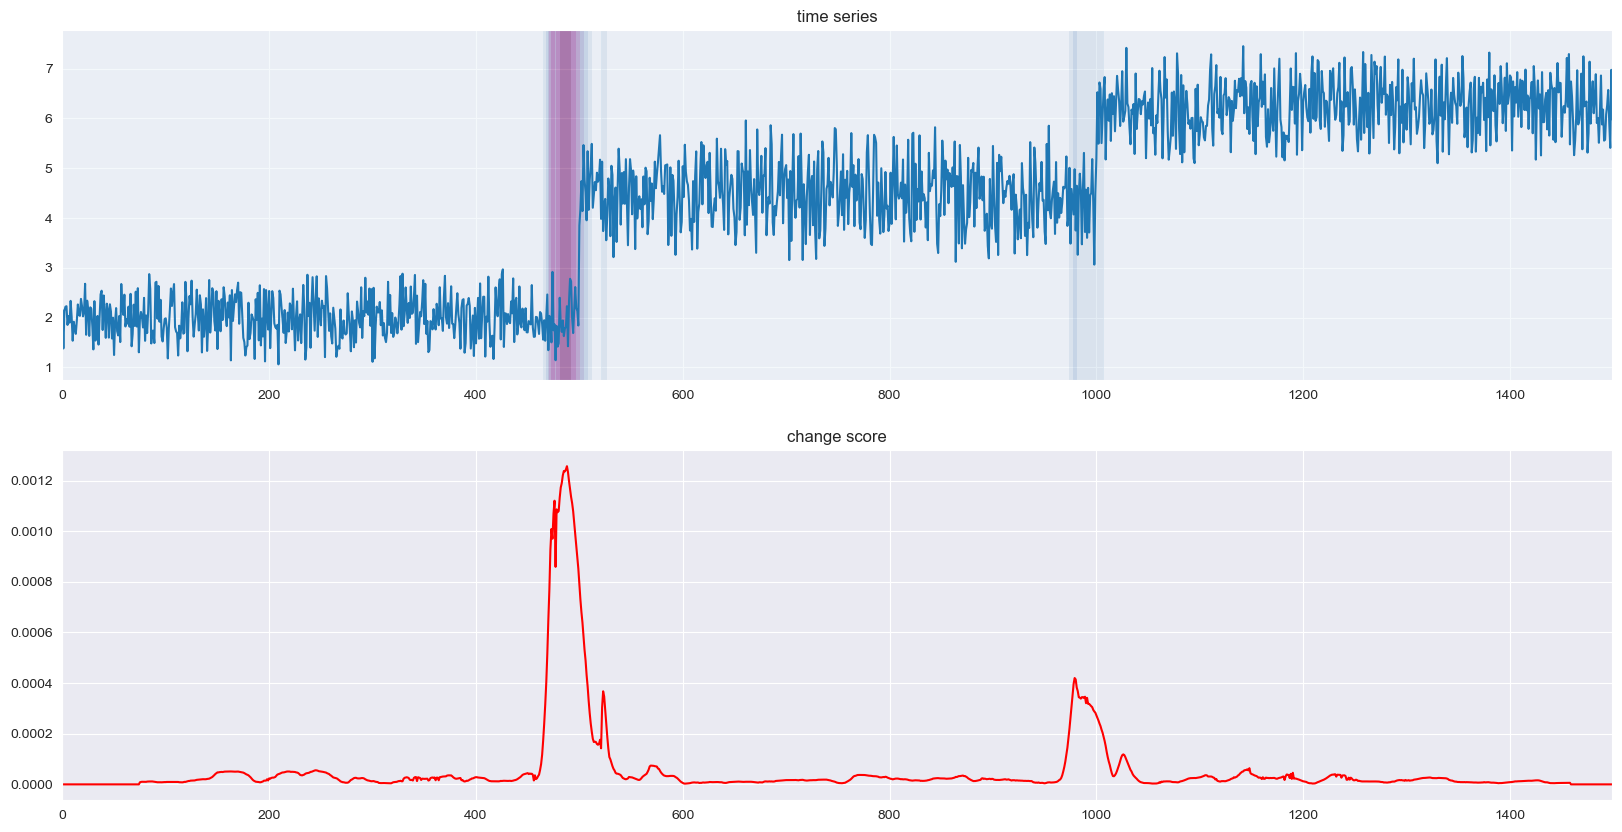

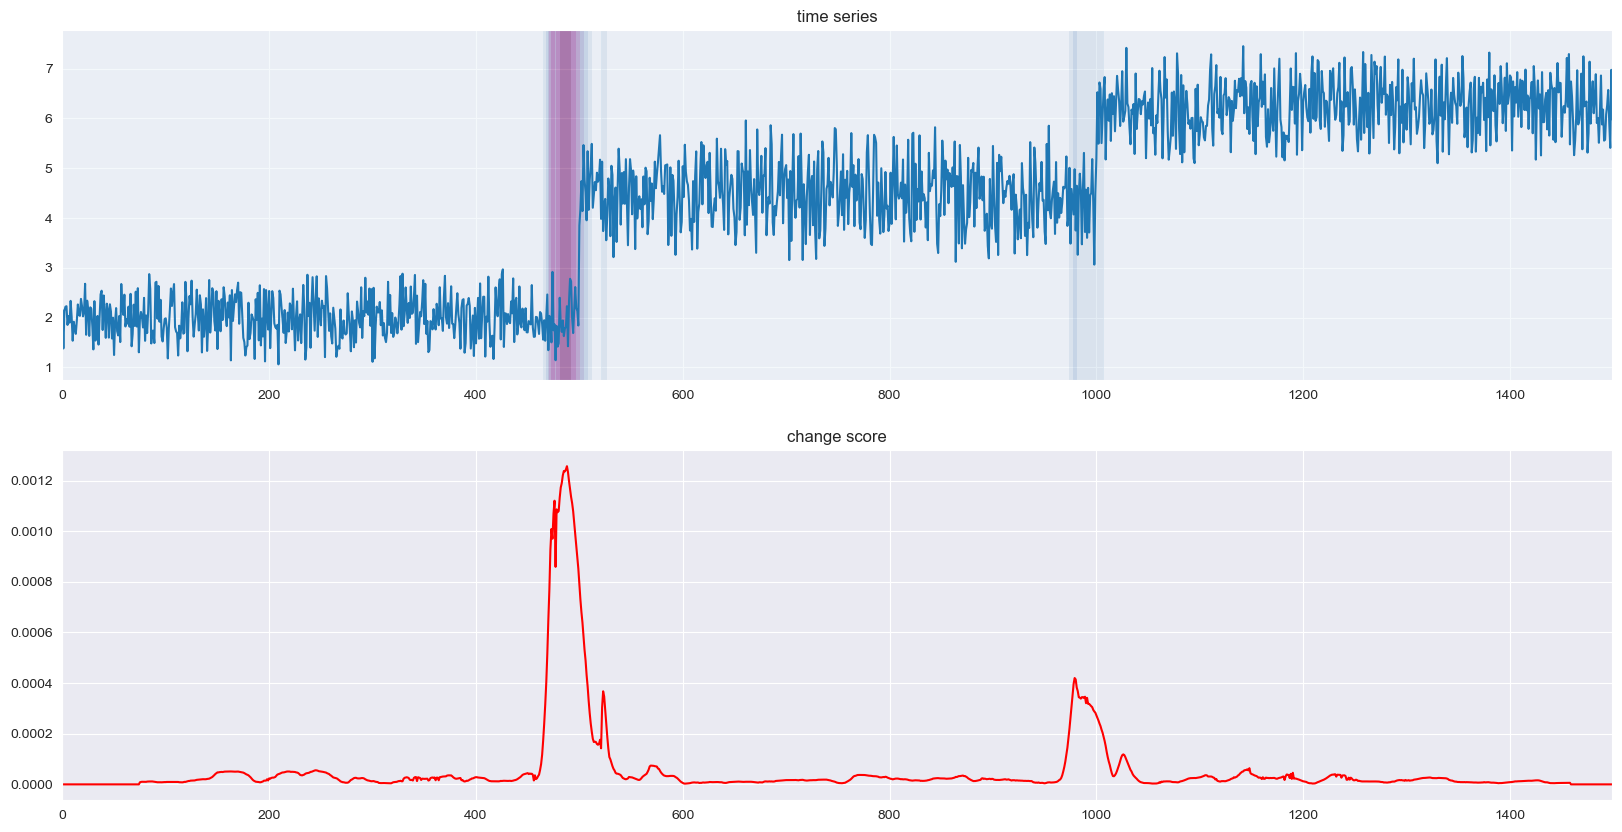

In [5]:
# compute change score using ika sst
score = SST(window_length=50, rank=5, method="ika").transform(x)
plot_data_and_score(x,score)

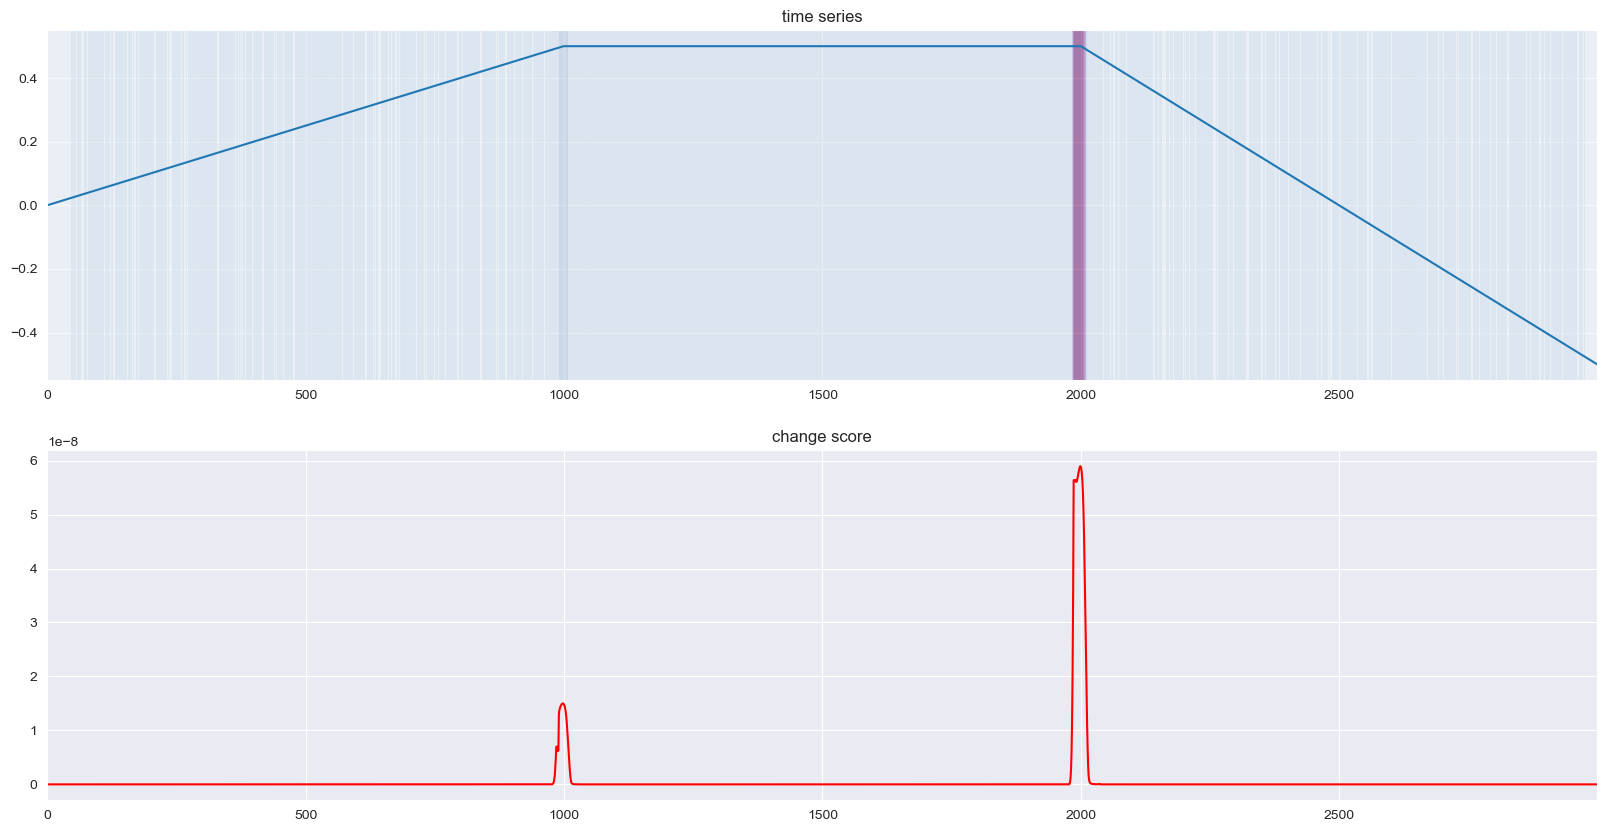

In [6]:
length = 1000
x2 = np.hstack([np.linspace(0, 0.5, num=length), 0.5 * np.ones(length) , np.linspace(0.5, -0.5, num=length)])
# compute change score using sst
score = SST(window_length=30, rank=5, method="svd").transform(x2)
plotted_score = plot_data_and_score(x2,score)

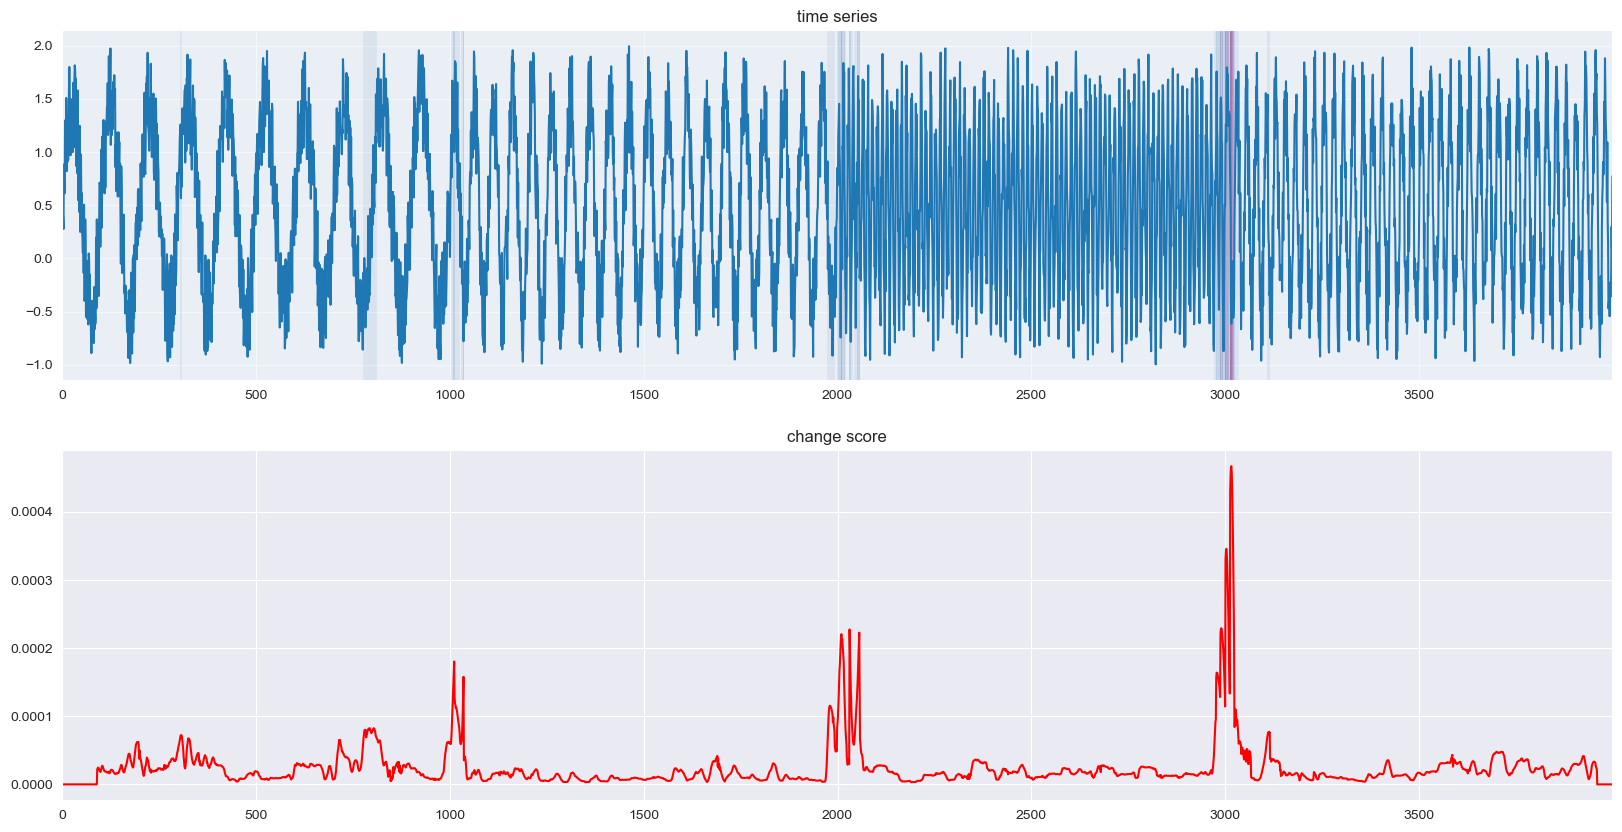

In [7]:
# synthetic (frequency change)
x0 = np.sin(2*np.pi*1*np.linspace(0,10,1000))
x1 = np.sin(2*np.pi*2*np.linspace(0,10,1000))
x2 = np.sin(2*np.pi*8*np.linspace(0,10,1000))
x3 = np.sin(2*np.pi*4*np.linspace(0,10,1000))
x = np.hstack([x0, x1, x2, x3])
x += np.random.rand(x.size)

# compute change score using sst
score = SST(window_length=60, lag=10, rank=5).transform(x)
plotted_score = plot_data_and_score(x,score)

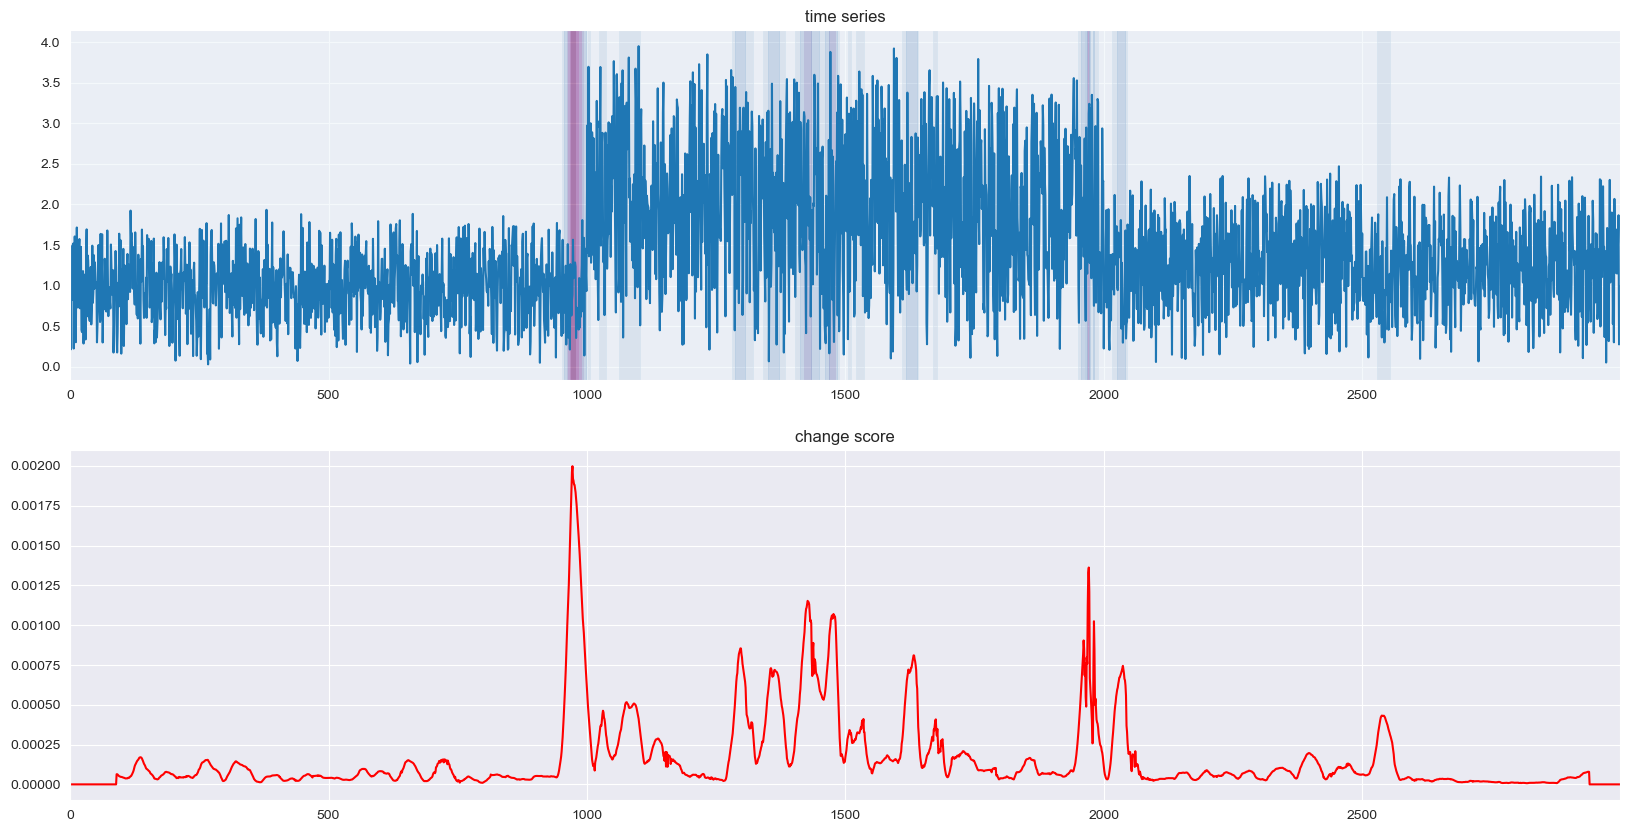

In [8]:
# make synthetic variance noise change
x0 = np.random.rand(1000) * 1
x1 = np.random.rand(1000) * 3
x2 = np.random.rand(1000) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

# compute change score using sst
score = SST(window_length=60, lag=30, rank=5).transform(x)
plotted_score = plot_data_and_score(x,score)